# Data Processing

In [2]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import numpy as np
import matplotlib.pyplot as plt

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# train_file_path = '/content/drive/My Drive/Colab Notebooks/NLPDisaster/train.csv'
train_file_path = 'Data/train.csv'
test_file_path = 'Data/test.csv'
# Read the CSV file into a DataFrame
df_dirty_train = pd.read_csv(train_file_path, delimiter=',')  # Use '\t' for tab-separated files
df_test = pd.read_csv(test_file_path, delimiter=',')

# Display the first few rows of the DataFrame
# df_train.head()
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Cleaning Training Data

In [55]:
# clean up data
# Drop the rows with duplicate text information
duplicate_mask = df_dirty_train.duplicated(subset='text', keep=False)

df_train = df_dirty_train[~duplicate_mask]
#df_train.to_csv('output_no_duplicates.csv', index=False)

# Display the duplicated rows
# duplicate_rows.to_csv('duplicate_rows.csv', index=False)

# df_train

#verify 
# duplicate_mask_verify = df_train.duplicated(subset='text', keep=False)
# test_mask = df_train[duplicate_mask_verify]
# test_mask


# make sure the target values of 0 or 1 are ints
df_train['target'] = df_train['target'].astype(int)

# make blank locations have unknown token
df_train['location'] = df_train['location'].fillna('[UNK]')
df_test['location'] = df_test['location'].fillna('[UNK]')

# if location is ? or is made up location change it to [UNK]
invalid_locations = ["Niall's place | SAF 12 SQUAD |",
 'threeonefive. ',
 '121 N La Salle St, Suite 500',
 'Vault 101, Fallout',
 '304',
 'In your hearts and minds',
 '#BlackLivesMatter',
 'USA - Global Online Sales ',
 'High in Prague with Aya',
 'Happily Married with 2 kids ',
 'born on september 1st',
 'Yeezy Taught Me , NV',
 'U.S.A.',
 'Wheeler,Wis.',
 'Instagram:marissatunis',
 'Somewhere in the Internet...',
 '1996???????????',
 '#Capulets #5SOSfam #5quadfam ',
 'ITUNES RADIO [Hiphop/Rap]',
 '3rd terrestrial planet, Sun',
 'My own little world.',
 '1937 Germany ',
 'Down, down, baby...,SC.',
 'Score More Goals Buying @',
 'KATONG PLAZA #02-10',
 'Score Team Goals Buying @',
 'Mo.City',
 "ZIKKO'S HQ",
 'VISIT MY YOUTUBE CHANNEL.',
 '??????????? :P',
 'Mass.',
 'Sherbrooke & MontrÌ©al',
 'psalms 27:1',
 'slytherin /',
 'Windy City, Land of the Snakes',
 '35% gay. 65% water. ',
 'Oh.',
 'cucumber squad | she/her | ',
 '8.27.14 & 7.28.15',
 'she/her ',
 'Romans 1:16',
 "Your Girl's Pussy",
 'twitch.tv/dgn_esports',
 'The other side of the mirror',
 'Sporting capital of the World',
 'mn |7-18-13|8-27-14|7-26-15|',
 'Ideally under a big tree',
 'The Land of Pleasant Living',
 'Crescent Moon w/ Wook',
 "305 but I'm So St. Louis...",
 'Quezon City, National Capital Region',
 'XIX | 5SOS | Ed Sheeran |',
 'Beacon Hills ~ The Glade',
 'IG: xbougiebri',
 '? the Foothills of SC ?',
 '22714 Ventura Blvd. WHills, CA',
 "Don't stalk me- thanks",
 'On The Island: Nassau, Bahamas',
 'Wolfgangmuzic@gmail.com',
 'O-Town , The left end',
 '10 hours from pluto',
 'NYC, ??, VAN',
 "N 51å¡25' 0'' / W 0å¡45' 0''",
 'VI~D[M]V',
 '#uniteblue',
 'Jon Bellion | Luke Christopher',
 'y/e/l',
 'IG: 94fijiwater',
 '?arsehole squad?',
 'Wherever the music takes me ',
 '?????????, ?????-?????????',
 'ÌÏT: 41.373061,-71.942237',
 'New Hampshire \x89Û¢ WMUR ',
 '557619',
 'daily ? 18 ? ?',
 'Epic City, BB.',
 'SW London (RBK)',
 'The Internet & NYC',
 'SQU\\/D, uk',
 '$$$',
 'Mid north coast of NSW',
 ';)',
 'among the socially awkward ?',
 'Toronto  #6ixSideMafia',
 'jonas/lovato/bieber/5sos',
 '#BVSTRONG',
 'Leanbox?',
 'www.facebook.com/Randirobics',
 '? In your head ?',
 'hyejeong?taehyung',
 '(queer, trans, he/him, black)',
 'Eugene, OR.',
 'sending rude things to heather',
 "luisa's heart",
 '#IzzoWorld',
 'INEQUITY  IS  INJUSTICE || NJ',
 'The Open road!',
 'The New Way To Surf!',
 'downriver.',
 '770 to Benedict College ',
 'isabel beatriz paras de leon',
 "N 32å¡39' 0'' / W 97å¡16' 0''",
 'it was yesterday :(',
 'dancer - Peter Pan panto 2015 ',
 '65 Skelmersdale Lane',
 'Does it really matter!',
 'In my baby with pie',
 'Also follow ?',
 "'schland",
 '????',
 '??????',
 'Hiding in a cardboard box.',
 '???????????',
 'Wherever the #Sooners are',
 ' Road to the Billionaires Club',
 'w/ @_ridabot, probably',
 'DC & MoCo',
 '/ Kattappana, Kerala ',
 'From Harlem to Duke ! ',
 'Cardiff/London/NYC/Warwick',
 '#Global',
 'Between Manchester and Lille.',
 'Curitiba-PR',
 "At Grandmother Willow's",
 '@ArgentinaLiars ?| willbradley',
 'The Interwebs!',
 'Please follow and RT! :)',
 'dam squad 4 lyf',
 'toronto \x89Û¢ unicorn island ',
 'EspaÌ±a/Catalunya/Girona',
 'U.S.',
 'Windsor ??CT ',
 '#NAME?',
 'land-where-everything-sucks',
 '3-Jan',
 "East Carolina University'19 ??",
 'FEMA REGION 2',
 'Ex Astris Scientia. TSSADID.',
 '130515 \x89Û¢ Gallavich.',
 'Playing: HL2: EP1, Dust: AET',
 'Do Not Follow Me, Am I a Bot.',
 'in the Word of God',
 'Here.',
 'Under the rain...',
 'Twitter.',
 'Metro, Lampung ~ Balikpapan',
 '32935',
 '301|804',
 'South Park  ??????????????????',
 "Ton's Ì¡ead town åÈ Tx",
 '#ViewsAreMyOwn #IBackTheBlue',
 '?? | pittsburgh ',
 'Berkeley, CA 94703, USA ? ',
 'Sydney - Australia',
 'she/her? \x89Û¢ tr \x89Û¢ jordan',
 'Seattle/Snohomish/Redlands',
 'Everywhere.. ',
 '~always in motion~',
 'ÌÏT: 39.168519,-119.766123',
 'Ittihad .f.c',
 'Ì\x81th Cliath, Ìäire',
 '?????',
 'Free Palestine | Save Gaza',
 'VH1 Soul in a BET World ',
 'Planet Earth (mainly) #Neuland',
 '??????????',
 'garbage disposal bc im trash',
 'Sherman ave South Bronx #STF',
 'Free Hanseatic City of Bremen, Germany',
 'a pool of my own tears',
 'From Boston, for New England',
 'live from the low end',
 'bestatriz \x89Û¢29/4 \x89Û¢ #askdemigod ',
 'Here, There & Everywhere..',
 'support all girls!',
 '36702 State Road 52, Dade City',
 'Miami - Support NAVY #SEALS ',
 'Babylon Up-On Hudson',
 'Sales Specialist~ Worldwide  ',
 'Rapid City & The Black Hills',
 'Bending the elements.',
 'Dark Night. ???? ??',
 'Sunderland/The Saaf',
 'For a healthier, happier YOU!',
 'vb/norfolk,va',
 'Chiba,very close to Tokyo.',
 '???? ???????',
 'In my head.....',
 'UK & Oversees',
 '???/??',
 '????? ?? ?????? -????? ????',
 '#HDYNATION',
 '??? ???? ??????',
 'Over the Hills and Far Away',
 'The Court of Public Opinion.',
 'http://wingssilverwork.com',
 'U.S.A. - Global Members Site',
 ' way way way up ??',
 'Visit our  dedicated website @',
 'Niels Groeneveld / RedSocks',
 'Behavioral Analysis Unit (BAU)',
 'my USA, åµ???? ?aÌÙ? ',
 'melbs 1/2 #rham',
 'Nj ?? Az ',
 '| INDIA |',
 'chapel hill, cary n.c.',
 'Covering the U.S.A.',
 '3/12 + Jake Miller',
 'www.dorsavi.com',
 '#RoshanPakistan',
 'Shangri-La',
 'Upper St. Clair',
 'NWA & River Valley',
 '17 year old anti-theist.',
 'Santos, SÌ£o Paulo',
 'House of the Rising Sun',
 '@KEYTNC3 @KCOY',
 'Ohio...yep we said it.',
 'Dili. East Timor',
 "Wouldn't u like to know",
 'St. Catherine, Jamaica, W.I.',
 'Kocaeli-Izmit',
 'tarn et garonne/lot et garonne',
 '1/11 numberjacks squad',
 'ÌÏT: 58.193556,-5.334943',
 'Canberra (mostly)',
 ' Stah-koomi-tapii-akii',
 ' ? they/them ?',
 'LastLevelPress.com',
 'The best side of middlesbrough',
 'U.S.A. ',
 'LND Greatest City In the World',
 'they/them or she/her',
 'Home is wherever I am ',
 '9.25.14?8.5.15?10.6.15 | gen?',
 'Uganda l Africa l Worldwide. ',
 '2014.02.14~ing',
 '#Bitcoinland',
 'ÌÏT: 41.106046,-80.657836',
 '?x??p = ?/2',
 'nipple squad makes me happy',
 'Try looking at the map?',
 'Toulouse Haute-Garonne France',
 'U.S.A.   FEMA Region 5',
 'Patra-Greece.',
 'ÌÏT: 50.953278,-113.978785',
 '9 Benua Ltd.',
 'ÌÏT: 7.384559,3.8793718',
 '#sundaunited',
 'U.K.',
 'GO Bucks!',
 'Tri-State',
 '#DCjacobin',
 'å©hicago',
 'UberlÌ¢ndia - MG - Brasil',
 'HUSTON TEXAS 1-844-360-WISE',
 'Globally 1-844-360-WISE',
 '55 Wall Street',
 'teen top ? jongsuk ? exo ? bts',
 "In ma daddy nd mummy's. Hart..",
 'WARNING: I TWEET NSFW AND NSFL',
 'started acc 1.9.15 2:25 pm',
 'she/her \x89Û¢ 19 \x89Û¢ poland',
 'Rice Lake, WI/Toronto, ON',
 'trust none..',
 'Honeymoon Tour 03.26.15?',
 "Trapin'",
 '#ALLblacklivesmatter',
 'stars/pens/caps/hawks',
 'In A Multi-Fandom',
 'Malta; Gozo',
 "Maryland/Myrtle Beach CCU'19",
 '#TeamHKNgang ',
 'they/them ',
 '62',
 'Atrapada en el mundo.',
 'IL?MI',
 '@rejxctedmgc is my Harry?',
 'ig: j.nessaa',
 'The Land of Make Believe',
 'Saint John, N.B, Canada ',
 'New England ????',
 '424 N. FAIRFAX AVE. 90036',
 'Where is my mind?',
 'North Coast of O-H-I-O',
 'BLF (MP)/ PTA (GP)/ PHB(LIMPS)',
 'SP - Brasil #1',
 'Fano (Italy)',
 'Seek for LIGHT today!!!',
 'YesNaija.com',
 '{Daughter of Ares} {Eighteen}',
 'vine: woah stelena ',
 '  ?becky?chloe?',
 'St. Catharines',
 "sarah's dreads",
 'Kearney (area) Nebraska',
 '???\x89Û¢???\x89Û¢s??\x89Û¢????\x89Û¢????????s',
 'm a a l k ',
 '6/24/12 7/21/13 8/22/14 7/17/15',
 'SDF-1 Macross S. Ataria Island',
 'SantibaÌ±ez de Vidriales ZAMORA',
 '(SoCal)',
 'Tampa Bay. Fire the cannons',
 '@kiarakardashhh | Fayetteville',
 'ny || ga',
 '336',
 'ÌÏT: 35.353272,-78.553744',
 'SÌ©te, France, (foto c.1968)',
 'http://www.amazon.com/dp/B00HR',
 'instagram- joeyparmenterr',
 'A glass case of emotions',
 'N.E.Ohio',
 '53.337853,-6.288693',
 'Time for NON VIOLENT dissent! ',
 'Lansing ?? Ypsilanti ',
 '??9?',
 'IG : Sincerely_TSUNAMI',
 'rest easy angel @datboiiharri.',
 'SIUC | 618',
 'http://t.co/mOY6lmu',
 'Philadelphia; World War I',
 'Shanatic/GGian/SRKian',
 'Richmond, VA & Bristow, VA',
 'Sawangan 1, Central Java',
 'MDS af ?',
 "Sky's The limit (B.I.G) ????",
 'icon: cheese3d',
 '????????',
 '??????????????',
 '( ?å¡ ?? ?å¡), ',
 '?orth, SG. ',
 'GARRUS?',
 'Sheffield.?',
 '140920-21 & 150718-19 BEIJING',
 "Where e'er the mood takes me",
 'Montana/North Carolina',
 'FRM JERZ LIVING IN DADE COUNTY',
 '408 N. Western, Wenatchee, WA ',
 '28.709672,-97.376514',
 '??',
 '?? Newport , RI ??',
 '626 - 702',
 'Back of the beyond, Lesotho',
 'CLT via NOLA via MO via MN',
 'the beautiful Northwest (USA)',
 'K-Town ',
 '#Kashmir',
 "sam's town",
 'St. Petersburg. Fla.',
 'would rather be in my room',
 'Philippians 4:13',
 'Deep in the heart of LibLand',
 'Planet Earth',
 'ss',
 'Everywhere',
 'everywhere',
 'Worldwide',
 'worldwide',
 'Global']
df_train['location'] = df_train['location'].apply(lambda x: '[UNK]' if (x.startswith('?') or x in invalid_locations) else x)

C:\Users\ldb0046\AppData\Local\Temp\ipykernel_33464\1994997605.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['target'] = df_train['target'].astype(int)
C:\Users\ldb0046\AppData\Local\Temp\ipykernel_33464\1994997605.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['location'] = df_train['location'].fillna('[UNK]')
C:\Users\ldb0046\AppData\Local\Temp\ipykernel_33464\1994997605.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

## Analysis of Training Data

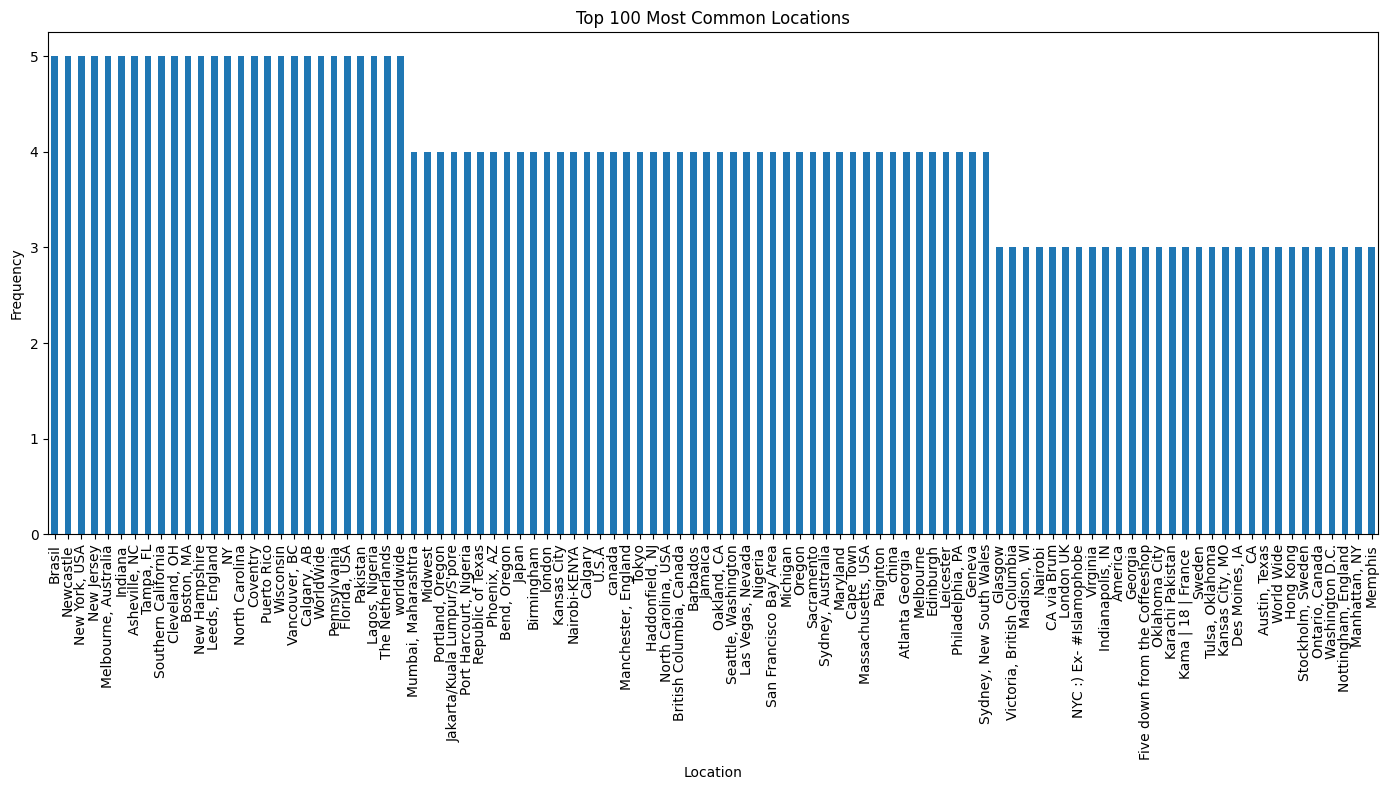

In [54]:
# data analysis
location_counts = df_train['location'].value_counts()

# Select the top 10 most common locations
top_n = 100
# top_locations = location_counts.head(top_n)
top_locations = location_counts.iloc[75:175]

# Plot the data
plt.figure(figsize=(14, 8))
top_locations.plot(kind='bar')
plt.title(f'Top {top_n} Most Common Locations')
plt.xlabel('Location')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

## Encoding Data

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#Tokenize the text data
train_text_encodings = tokenizer(
    list(df_train['text'].values),
    add_special_tokens=True,
    max_length=128,
    padding=True,
    truncation=True,
    return_tensors='pt'
)

train_location_encodings = tokenizer(
    list(df_train['location'].values),
    add_special_tokens=True,
    max_length=32,
    padding=True,
    truncation=True,
    return_tensors='pt'
)

test_text_encodings = tokenizer(
    list(df_test['text'].values),
    add_special_tokens=True,
    max_length=128,
    padding=True,
    truncation=True,
    return_tensors='pt'
)

test_location_encodings = tokenizer(
    list(df_test['location'].values),
    add_special_tokens=True,
    max_length=32,
    padding=True,
    truncation=True,
    return_tensors='pt'
)


print("Text input_ids size:", train_text_encodings['input_ids'].size())
print("Text attention_mask size:", train_text_encodings['attention_mask'].size())
print("Location input_ids size:", train_location_encodings['input_ids'].size())
print("Location attention_mask size:", train_location_encodings['attention_mask'].size())
print("Targets size:", torch.tensor(df_train['target'].values).size())


7613
7613


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Text input_ids size: torch.Size([7613, 84])
Text attention_mask size: torch.Size([7613, 84])
Location input_ids size: torch.Size([7613, 30])
Location attention_mask size: torch.Size([7613, 30])
Targets size: torch.Size([7613])


In [6]:
# input IDS are the token IDs for every token in the text
# attention mask tells the model the location of actual tokens and the pos of padding tokens (note useful)
# we have to add padding tokens to make all the inputs be the same size

train_dataset = TensorDataset(
    train_text_encodings['input_ids'],
    train_text_encodings['attention_mask'],
    train_location_encodings['input_ids'],
    train_location_encodings['attention_mask'],
    torch.tensor(df_train['target'].values)
)

test_dataset = TensorDataset(
    test_text_encodings['input_ids'],
    test_text_encodings['attention_mask'],
    test_location_encodings['input_ids'],
    test_location_encodings['attention_mask']
)

# this is a way for the data to be randomized during every epoch of training. Also makes easier to parallelize
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Model Training

In [11]:
import torch.nn as nn
from transformers import BertModel

class BertClassifier(nn.Module):
    def __init__(self, bert_model_name, num_labels):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size * 2, num_labels)  # *2 for concatenation

    def forward(self, input_ids, attention_mask, location_ids, location_attention_mask):
        text_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        location_outputs = self.bert(input_ids=location_ids, attention_mask=location_attention_mask)
        
        # Concatenate the pooled outputs
        pooled_output = torch.cat((text_outputs[1], location_outputs[1]), dim=1)
        logits = self.classifier(pooled_output)

        return logits


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# two labels are 1 (disaster) or 0 (no disaster)
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# trying to init a custom bert model
model = BertClassifier(bert_model_name='bert-base-uncased', num_labels=2)
model = model.to(device)

In [14]:
# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * 3  # Assuming 3 epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
loss_fn = torch.nn.CrossEntropyLoss().to(device)


In [17]:
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        location_ids = batch[2].to(device)
        location_attention_mask = batch[3].to(device)
        targets = batch[4].to(device)

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            location_ids=location_ids,
            location_attention_mask=location_attention_mask
        )
        
        # Calculate loss
        loss = loss_fn(outputs, targets)

        # Get predictions
        _, preds = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)


In [19]:
EPOCHS = 10
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        optimizer,
        device,
        scheduler
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')


Epoch 1/10
----------
Train loss 0.1563052667750969 accuracy 0.9473269407592276
Epoch 2/10
----------
Train loss 0.1565394875116083 accuracy 0.9462761066596611
Epoch 3/10
----------
Train loss 0.15762096243527005 accuracy 0.9483777748587942
Epoch 4/10
----------
Train loss 0.1584362470067474 accuracy 0.9465388151845527
Epoch 5/10
----------
Train loss 0.15533585031321193 accuracy 0.9474582950216734
Epoch 6/10
----------
Train loss 0.1559825110006608 accuracy 0.9479837120714567
Epoch 7/10
----------
Train loss 0.1565909450560683 accuracy 0.9453566268225404
Epoch 8/10
----------
Train loss 0.1563727571472463 accuracy 0.9478523578090109
Epoch 9/10
----------
Train loss 0.1585575407370925 accuracy 0.944962564035203
Epoch 10/10
----------
Train loss 0.15799362630732044 accuracy 0.945619335347432


In [10]:
#Save Model Weights
model_save_path = 'bert_disaster_tweets_WEIGHTS_10.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to bert_disaster_tweets_WEIGHTS.pth


In [12]:
# Load the model on another machine
model_load_path = 'bert_disaster_tweets_WEIGHTS.pth'

# Ensure you have the same architecture and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Load the saved weights
model.load_state_dict(torch.load(model_load_path))
model = model.to(device)
model.eval()
print(f"Model loaded from {model_load_path}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from bert_disaster_tweets_WEIGHTS.pth


# Model Predictions

In [20]:
def get_predictions(model, data_loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            location_ids = batch[2].to(device)
            location_attention_mask = batch[3].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                location_ids=location_ids,
                location_attention_mask=location_attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)

    predictions = torch.stack(predictions).cpu()
    return predictions

In [21]:
# Get predictions for the test data
test_predictions = get_predictions(model, test_data_loader)

# Save the predictions to a CSV file
submission = pd.DataFrame({
    'id': df_test['id'],
    'target': test_predictions.numpy()
})

submission.to_csv('submission_LOC.csv', index=False)
print("Predictions saved to submission.csv")

TypeError: BertClassifier.forward() missing 2 required positional arguments: 'location_ids' and 'location_attention_mask'